In [3]:
pip install kagglehub seaborn torchvision torch

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

path = 'archive (3)/animals'



dataset = datasets.ImageFolder(
    root=path,
    transform=transform
)




train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



c:\Users\SEC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SEC\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\SEC/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [00:35<00:00, 15.6MB/s] 


Epoch [1/5], Loss: 11.5725
Epoch [2/5], Loss: 2.4252
Epoch [3/5], Loss: 0.9137
Epoch [4/5], Loss: 0.8850
Epoch [5/5], Loss: 0.4295
Classification Report:
              precision    recall  f1-score   support

        cats       0.98      0.98      0.98       204
        dogs       0.98      0.97      0.97       206
       panda       0.98      0.99      0.99       190

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



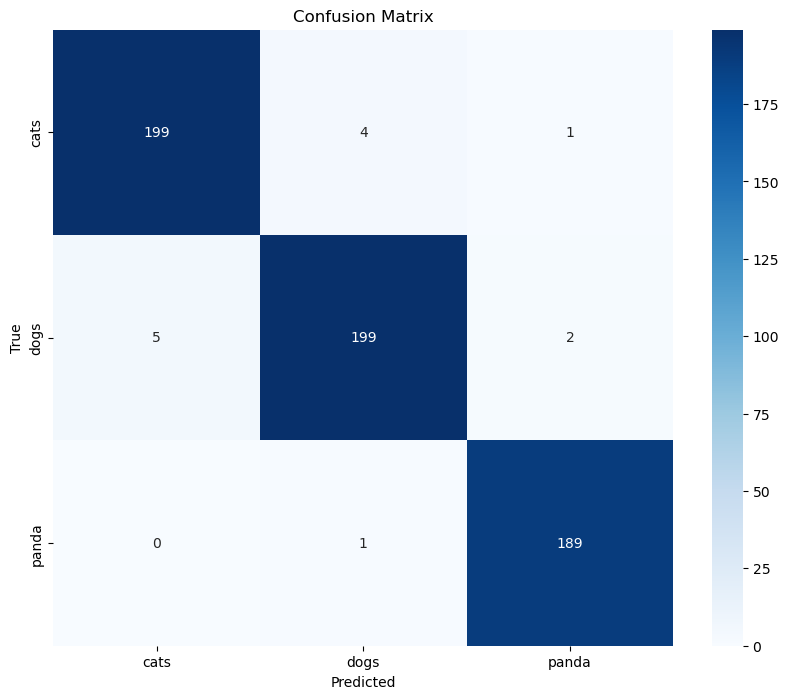

In [6]:
vgg = models.vgg16(pretrained=True)

for param in vgg.features.parameters():
    param.requires_grad = False

num_classes = len(dataset.classes)

vgg.classifier = nn.Sequential(
    nn.Linear(25088, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

model = vgg.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=1e-5)

epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Validation Classification Report:
              precision    recall  f1-score   support

        cats       0.93      0.99      0.96      1000
        dogs       0.99      0.93      0.96      1000
       panda       0.99      0.98      0.99      1000

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



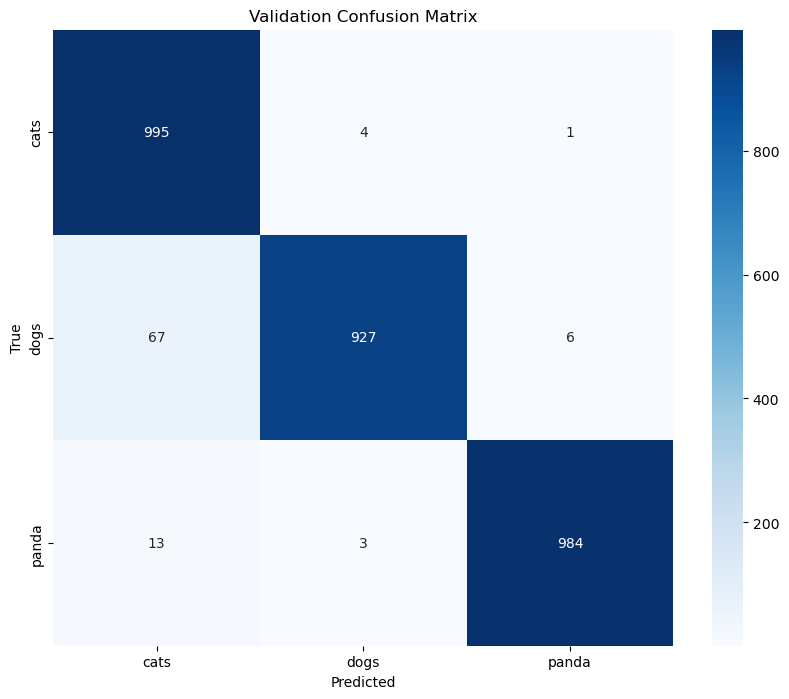

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the same transforms used for training
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # same as training
    transforms.ToTensor(),
])

# Load validation dataset
val_dataset = datasets.ImageFolder('archive (3)/validation', transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Evaluate on validation set
model.eval()
val_y_true, val_y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_y_true.extend(labels.numpy())
        val_y_pred.extend(predicted.cpu().numpy())

# Print classification report
from sklearn.metrics import classification_report, confusion_matrix
print("Validation Classification Report:")
print(classification_report(val_y_true, val_y_pred, target_names=val_dataset.classes))

# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(val_y_true, val_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_dataset.classes,
            yticklabels=val_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Validation Confusion Matrix")
plt.show()


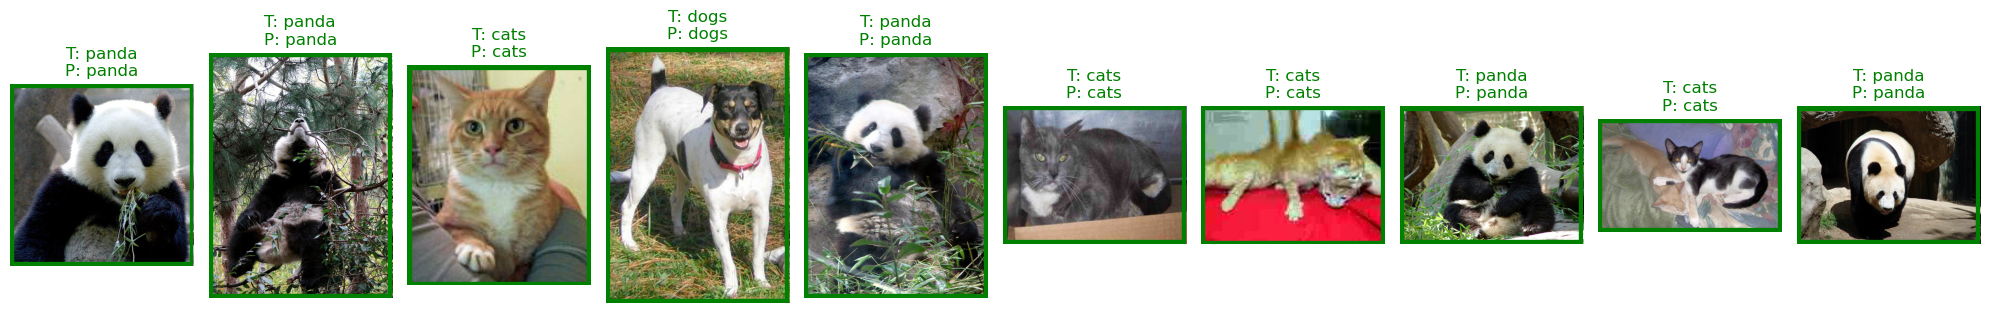

In [8]:
import torch
import torchvision.transforms as transforms
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.save(model.state_dict(), "animal_classifier.pth")

model.load_state_dict(torch.load("animal_classifier.pth", map_location=device))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

val_dir = 'archive (3)/validation'
class_names = sorted(os.listdir(val_dir))

num_samples = 10
fig, axs = plt.subplots(1, num_samples, figsize=(20, 6))

all_classes = os.listdir(val_dir)
for i in range(num_samples):
    true_class = random.choice(all_classes)
    class_folder = os.path.join(val_dir, true_class)
    image_name = random.choice(os.listdir(class_folder))
    image_path = os.path.join(class_folder, image_name)

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, pred_idx = torch.max(output, 1)
        pred_class = class_names[pred_idx.item()]

    axs[i].imshow(image)
    axs[i].axis('off')

    correct = true_class == pred_class
    title_color = "green" if correct else "red"
    axs[i].set_title(f"T: {true_class}\nP: {pred_class}", fontsize=12, color=title_color)

    edge_color = 'green' if correct else 'red'
    axs[i].add_patch(Rectangle((0, 0), image.size[0], image.size[1], linewidth=6, edgecolor=edge_color, facecolor='none'))

plt.tight_layout()
plt.show()
